# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit your completed notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment

In [2]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from IPython.display import display

# To get geo info of IP addresses:
# !pip install maxminddb-geolite2
from geolite2 import geolite2

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts

The dataset `customer_data.csv` lists certain attributes providing valuable insights into customer behavior and demographics:

- **full.name**: Customer's full name
- **ip.address**: Customer's IP address
- **region**: Customer's geographical region
- **age**: Customer's age
- **items**: Number of items purchased by the customer
- **amount**: The total amount spent by the customer

Businesses can leverage this dataset to make data-driven decisions, understand customer preferences, and tailor their strategies to meet customer needs and interests.


### 1.1 Load the dataset and display the first 5 rows.

In [3]:
#your code here
customer_data = pd.read_csv('customer_data.csv')
customer_data.head()

,full.name,ip.address,region,in.store,age,items,amount
0,Carter Stokes,NaN,2,0,37,4,281.03
1,Jacob Jerde,NaN,2,0,35,2,219.51
2,Tressa Ratke,192.90.208.202,4,1,45,3,1525.70
3,Rudolf Abshire,251.55.128.164,3,1,46,3,715.25
4,Theresa Davis,182.19.192.186,1,1,33,4,1937.50


### 1.2 First, remove any rows where the entry of "Age" column is below 18 or above 80, and then extract two new features from `ip.address`: one called `latitude` and the other `longitude`. Use the package `geolite2` for the conversion of the IP addresses to latitude and longitude. Use [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to do the conversion (in a vectorized way) in one go for each new feature. Avoid using `for` loops. At the end, drop the column `ip.address` as well as any rows with a missing value. Display the first 5 rows of the new dataframe and report its shape.

In [4]:
#your code here
customer_data = customer_data[(customer_data['age'] >= 18) & (customer_data['age'] <= 80)].copy()

reader = geolite2.reader()
customer_data.dropna(inplace=True)
customer_data["ip.address"] = customer_data["ip.address"].apply(lambda x: reader.get(x) if x else None)
customer_data['latitude'] = customer_data["ip.address"].apply(lambda x: x['location']['latitude'] if isinstance(x, dict) and 'location' in x and 'latitude' in x['location'] else None)
customer_data['longitude'] = customer_data["ip.address"].apply(lambda x: x['location']['longitude'] if isinstance(x, dict) and 'location' in x and 'longitude' in x['location'] else None)
customer_data.drop("ip.address", axis=1, inplace=True)
customer_data.dropna(inplace=True)
customer_data.reset_index(inplace=True, drop=True)

print("Shape of the dataframe after age filtering:", customer_data.shape)
customer_data.head()

Shape of the dataframe after age filtering: (34303, 8)


,full.name,region,in.store,age,items,amount,latitude,longitude
0,Tressa Ratke,4,1,45,3,1525.70,42.5879,-71.3498
1,Theresa Davis,1,1,33,4,1937.50,1.2931,103.8558
2,Keitha Mosciski,3,1,66,5,819.98,40.0842,-82.9378
3,Hortense Streich,1,1,51,5,908.31,37.7510,-97.8220
4,Carl Price,1,1,47,3,767.54,41.3969,-87.3274


### 1.3 Perform one-hot encoding on the `region` column using pd.get_dummies(). Display the first 5 rows of the encoded dataframe.

In [ ]:
#your code here
encoded_data = pd.get_dummies(customer_data, columns=['region'], prefix=['region'], drop_first=True)
display(encoded_data.head())

,full.name,in.store,age,items,amount,latitude,longitude,region_3,region_4
0,Tressa Ratke,1,45,3,1525.70,42.5879,-71.3498,0,1
1,Theresa Davis,1,33,4,1937.50,1.2931,103.8558,0,0
2,Keitha Mosciski,1,66,5,819.98,40.0842,-82.9378,1,0
3,Hortense Streich,1,51,5,908.31,37.7510,-97.8220,0,0
4,Carl Price,1,47,3,767.54,41.3969,-87.3274,0,0


### 1.4 Calculate the natural logarithm of the column reporting clients' total amount spent and store it as a new column `log_amount`. Create your design matrix `X` and target vector `y` with `log_amount` as target (No training/test splitting yet).



In [ ]:
#your code here
encoded_data['log_amount'] = np.log(customer_data['amount'])
# Create the design matrix X
X = encoded_data.drop(columns=['log_amount', 'amount'])
y = encoded_data['log_amount']

### 1.5 Build a new design matrix by applying polynomial expansion using `PolynomialFeatures()` on `X` with degree=2. Do not include the column with power 0 (*i.e.*, the column with all elements being 1) and make sure to not set the argument `interaction_only` to `True`.


In [ ]:
# Identify and remove non-numeric columns (i.e., "full.name") from X
X_numeric = X.drop(columns=['full.name'])

# Apply polynomial expansion with degree=2 on the numeric columns
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_numeric = poly.fit_transform(X_numeric)


### 1.6 Standardize your design matrix from Question 1.5 using `StandardScaler()`, and store the result as a Pandas dataframe.

In [ ]:
#your code here
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_poly_numeric)
X_standardized_df = pd.DataFrame(X_standardized)
X_standardized_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,0.145816,-0.725372,0.444623,-0.647114,-0.617623,1.439381,0.0,0.145816,-0.725372,...,0.405456,-0.736243,-0.525188,1.630553,-0.517981,0.075731,-1.303378,-0.617623,0.0,1.439381
1,0.0,-0.718845,-0.240069,-1.770476,1.307583,-0.617623,-0.694743,0.0,-0.718845,-0.240069,...,-2.130086,0.259804,-0.525188,-0.576082,0.427101,0.075731,0.083220,-0.617623,0.0,-0.694743
2,0.0,1.658972,0.245233,0.310322,-0.776396,1.619110,-0.694743,0.0,1.658972,0.245233,...,0.115829,-0.825979,1.679576,-0.576082,-0.221295,-1.670095,0.083220,1.619110,0.0,-0.694743
3,0.0,0.578146,0.245233,0.185166,-0.942453,-0.617623,-0.694743,0.0,0.578146,0.245233,...,-0.138285,-0.941622,-0.525188,-0.576082,0.225168,0.075731,0.083220,-0.617623,0.0,-0.694743
4,0.0,0.289926,-0.725372,0.380736,-0.825369,-0.617623,-0.694743,0.0,0.289926,-0.725372,...,0.265494,-0.917200,-0.525188,-0.576082,-0.097270,0.075731,0.083220,-0.617623,0.0,-0.694743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34298,0.0,0.001706,1.701141,-0.337422,-0.774250,-0.617623,1.439381,0.0,0.001706,1.701141,...,-1.034723,-0.509892,-0.525188,0.875151,-0.226585,0.075731,-1.524838,-0.617623,0.0,1.439381
34299,0.0,0.289926,-0.725372,0.745662,0.331503,1.619110,-0.694743,0.0,0.289926,-0.725372,...,1.118395,0.465289,2.125972,-0.576082,-1.318310,0.420248,0.083220,1.619110,0.0,-0.694743
34300,0.0,2.019248,-0.725372,0.161199,-1.213252,-0.617623,-0.694743,0.0,2.019248,-0.725372,...,-0.185208,-1.212146,-0.525188,-0.576082,1.110961,0.075731,0.083220,-0.617623,0.0,-0.694743
34301,0.0,0.434036,-0.240069,0.593043,-0.694278,-0.617623,-0.694743,0.0,0.434036,-0.240069,...,0.745937,-0.858406,-0.525188,-0.576082,-0.414908,0.075731,0.083220,-0.617623,0.0,-0.694743


## Question 2: /7 pts



### 2.1 Split the data into training and test sets. Hold out 30% of observations as the test set. How many observations are in your training dataset? What is the average value of the target variable in the training dataset (rounded to 2 decimal places)?

In [ ]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(X_standardized_df, y, test_size=0.3, random_state=seed)
num_observations = X_train.shape[0]
avg_target_value = round(y_train.mean(), 2)
print("Number of observations in the training dataset:", num_observations)
print("Average value of the target variable in the training dataset:", avg_target_value)

Number of observations in the training dataset: 24012
Average value of the target variable in the training dataset: 6.38


## Question 3: /23 pts



### 3.1 Create a SciKit Learn `Ridge` regression object. Train it on the training data using an `alpha` of $4.0$ and do fit the intercept.

In [ ]:
#your code here
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=4.0, fit_intercept=True)
ridge.fit(X_train, y_train)

Ridge(alpha=4.0)

### 3.2 Now use `RidgeCV` to find the best `alpha` for the penalty term through a 5-fold cross-validation. As input for `alpha`, your code must try integer values from 30 to 50 inclusive. Report the `alpha` that yields the smallest loss.

In [ ]:
#your code here
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(alphas=np.linspace(30, 50, 21).astype('i'), fit_intercept=True, cv=5)
ridgecv.fit(X_train, y_train)
best_alpha = ridgecv.alpha_
best_alpha

45

### 3.3 Fit a `Ridge` regression on the training data with the best `alpha` found in the previous question.

In [ ]:
#your code here
ridge_best = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_best.fit(X_train, y_train)


Ridge(alpha=45)

### 3.4 Fit a simple `LinearRegression` without any penalty using the training data (again, `fit_intercept=True`). Compare the regression coefficients obtained in questions 3.1, 3.3 and 3.4. How do they compare?

In [ ]:
#your code here
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)

print(abs(linear_reg.coef_).sum())
print(abs(ridge.coef_).sum())
print(abs(ridge_best.coef_).sum())

1.0102887980014412
1.0064534665388003
0.9688610241970896


#### YOUR ANSWER HERE

Ridge regression attempts to push the coefficients towards zero. The ridge model that used the penalty strength found through cross-validation was more successful in this regard.


### 3.5 Use your trained linear regression models in Q3.3 and Q3.4 to predict over the test set and print the median of their perdictions.

In [ ]:
#your code here
y_pred_linear = linear_reg.predict(X_test)
y_pred_ridge_best = ridge_best.predict(X_test)

print("First 5 prediction values from Linear Regression:", np.median(y_pred_linear))
print("First 5 prediction values from Linear Regression:", np.median(y_pred_ridge_best))

First 5 prediction values from Linear Regression: 6.388540271138073
First 5 prediction values from Linear Regression: 6.386258603316996


## Question 4: /25 pts



### 4.1 Fit a Lasso regression to the train dataset using lasso_path(). Show the full path of the first 20 coefficients of the Lasso regression. Include eps=8e-3 and n_alphas=50. Describe the trends that you see in the figure.



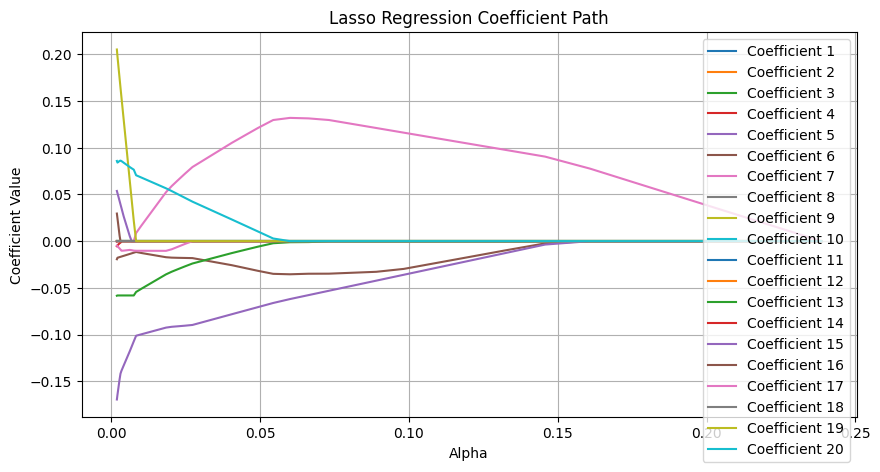

In [ ]:
#your code here
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path

alphas, coefs, _ = lasso_path(X_train, y_train, eps=8e-3, n_alphas=50)
plt.figure(figsize=(10, 5))
for i in range(20):
    plt.plot(alphas, coefs[i], label=f'Coefficient {i+1}')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficient Path')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Describe the trend: As alpha increases, the Lasso regression coefficients tend to become more sparse.
# Many coefficients shrink to zero, helping with the cancellation of features that model deems as unimportant.

### 4.2 Use Scikit Learn's cross-validated LASSO to automatically search for the best alpha of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameters and the number of coefficients that the model shrinks to zero.

In [ ]:
#your code here
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, fit_intercept=True)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.alpha_
non_zero_coeffs = np.sum(lasso_cv.coef_ != 0)

print("Best alpha for Lasso regression:", best_alpha_lasso)
print("Number of coefficients shrunk to zero:", lasso_cv.coef_.shape[0]-np.sum(lasso_cv.coef_ != 0))

Best alpha for Lasso regression: 0.001794689770779743
Number of coefficients shrunk to zero: 14



### 4.3 Use Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the ElasticNet regression (with intercept) on the training set. Include the same arguments as in question 4.2 as well as `l1_ratio=[0.7, 0.9, 0.95, 0.99, 1]`. Report the best tuning parameters. Is the ElasticNet regression model equivalent to the Lasso regression? Briefly describe how they defer and under what circumstances they become the same.

In [ ]:
#your code here
from sklearn.linear_model import ElasticNetCV

l1_ratios = [0.7, 0.9, 0.95, 0.99, 1]
elasticnet_cv = ElasticNetCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, l1_ratio=l1_ratios, random_state=seed, fit_intercept=True)
elasticnet_cv.fit(X_train, y_train)

best_alpha_elasticnet = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_

print("Best alpha for ElasticNet regression:", best_alpha_elasticnet)
print("Best l1_ratio for ElasticNet regression:", best_l1_ratio)

Best alpha for ElasticNet regression: 0.001794689770779743
Best l1_ratio for ElasticNet regression: 1.0


#### YOUR ANSWER HERE

The ElasticNet regression model is not equivalent to the Lasso regression because ElasticNet combines both L1 (Lasso) and L2 (Ridge) regularization. The best l1_ratio value for ElasticNet determines the trade-off between L1 and L2 regularization. When l1_ratio is 1, ElasticNet becomes equivalent to Lasso (pure L1 regularization). When l1_ratio is 0, it is equivalent to Ridge (pure L2 regularization). For other values, it combines both L1 and L2 regularization, providing a compromise between feature selection (L1) and handling multicollinearity (L2).

## Question 5 : /16 pts



### 5.1 Use `SequentialFeatureSelector()` to conduct forward selection for the features of the Ridge model tuned in Q 3.3. Include the argument `n_features_to_select=20`. Report the indices of the selected features.

In [ ]:
#your code here

from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(ridge_best, n_features_to_select=20, direction='forward')
sfs.fit(X_train, y_train)
selected_feature_indices = sfs.get_support(indices=True)

print("Indices of the selected features:", selected_feature_indices)

Indices of the selected features: [ 0  1  5  6  7  8  9 12 13 14 18 19 23 24 26 28 30 32 33 34]


### 5.2 Fit a regular `LinearRegression` (with `fit_intercept=True`) on the training set using the selected features from the previous question. Print the first 3 coefficients of your model.

In [ ]:
#your code here

X_train_selected = X_train.iloc[:, selected_feature_indices]
linear_reg_selected = LinearRegression(fit_intercept=True)
linear_reg_selected.fit(X_train_selected, y_train)

# Print the first 3 parameters of the model
print("First 3 parameters of the Linear Regression model with selected features:\n", linear_reg_selected.coef_[:3])

First 3 parameters of the Linear Regression model with selected features:
 [ 0.00000000e+00  4.59705469e+10 -3.33524694e+12]


## Question 6: /9 pts



### 6.1 Make predictions on the test set using models from questions 3.3, 4.2, 4.3, and 5.2, respectively. Create a DataFrame with  predicted values obtained from the different models. Name the columns of the dataframe consistent with the names used for the models, or their question number. Display the first 5 rows of this dataframe.

In [ ]:
# Predictions using Ridge (Q3.3)
y_pred_ridge = ridge_best.predict(X_test)

# Predictions using Lasso (Q4.2)
y_pred_lasso = lasso_cv.predict(X_test)

# Predictions using ElasticNet (Q4.3)
y_pred_elasticnet = elasticnet_cv.predict(X_test)

# Predictions using Linear Regression with selected features (Q5.2)
X_test_selected = X_test.iloc[:, selected_feature_indices]
y_pred_linear_selected = linear_reg_selected.predict(X_test_selected)

# Create a DataFrame with predictions
prediction_df = pd.DataFrame({
    'Ridge Predictions': y_pred_ridge,
    'Lasso Predictions': y_pred_lasso,
    'ElasticNet Predictions': y_pred_elasticnet,
    'Linear Regression (Selected Features) Predictions': y_pred_linear_selected
})

# Display the first 5 rows of the prediction DataFrame
print(prediction_df.head())

   Ridge Predictions  Lasso Predictions  ElasticNet Predictions  \
0           6.047282           6.042176                6.042176   
1           5.985070           6.038171                6.038171   
2           6.038782           6.008854                6.008854   
3           6.065787           6.040639                6.040639   
4           6.347867           6.329057                6.329057   

   Linear Regression (Selected Features) Predictions  
0                                           6.066218  
1                                           5.990535  
2                                           6.029109  
3                                           6.079890  
4                                           6.315242  


### 6.2 Use `mean_squared_error` as your scorer to assess the performance of the different models (those reported in the previous question) based on all the predicted values over test set. Based on this scorer which model is the best?

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate mean squared error for each model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
mse_linear_selected = mean_squared_error(y_test, y_pred_linear_selected)

# Find the model with the smallest mean squared error
smallest_mse_model = None
smallest_mse = float('inf')
if mse_ridge < smallest_mse:
    smallest_mse = mse_ridge
    smallest_mse_model = 'Ridge'
if mse_lasso < smallest_mse:
    smallest_mse = mse_lasso
    smallest_mse_model = 'Lasso'
if mse_elasticnet < smallest_mse:
    smallest_mse = mse_elasticnet
    smallest_mse_model = 'ElasticNet'
if mse_linear_selected < smallest_mse:
    smallest_mse = mse_linear_selected
    smallest_mse_model = 'Linear Regression (Selected Features)'

print("Model with the smallest mean squared error on the test dataset:", smallest_mse_model)
print("Smallest mean squared error:", smallest_mse)


Model with the smallest mean squared error on the test dataset: Lasso
Smallest mean squared error: 0.6023647936137447


#### YOUR ANSWER HERE

The model with the smallest MSE.

Note that though, this is not the way that we select a model. Here we are just experimenting to see the effect of regularization etc., else, we should use cross-validation and look at the CI.